# Airbus Ship Detection U-Net (dice score)
This notebook contains a UNet implementation for solving the ship recognition problem in the Kaggle competition [Airbus Ship Detection Challenge](https://www.kaggle.com/competitions/airbus-ship-detection/code?competitionId=9988&sortBy=voteCount).

### Importing libraries 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
import os

from skimage.morphology import label

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
IMG_CHANNELS = 3
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
epochs=1
batch_size=10
image_shape=(768, 768)
FAST_RUN=False # use for development only
FAST_PREDICTION=False # use for development only

## 1-DATA

In this part, we need to analyze the data we are working with.

In [3]:
train_v2 = os.listdir("train_v2/")
test_v2 = os.listdir("test_v2/")

In [4]:
train_mask = pd.read_csv('train_ship_segmentations_v2.csv')
train_mask.shape

(231723, 2)

In [5]:
train_mask.tail(10)

,ImageId,EncodedPixels
231713,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...
231714,fffdd2377.jpg,333603 7 334359 19 335120 26 335888 26 336656 ...
231715,fffe4c385.jpg,NaN
231716,fffe4fa23.jpg,NaN
231717,fffe646cf.jpg,NaN
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN
231722,ffffe97f3.jpg,NaN


From the table we can see that some data are missing. This means that there is no ship on the picture. Let's count number of non-empty values.

In [6]:
non_empty = pd.notna(train_mask.EncodedPixels)
non_empty.sum()

81723

In [7]:
train_mask[non_empty].ImageId.nunique()

42556

It means that we have 81723 masks in 42556 images.

In [8]:
train_v2 = os.listdir('train_v2')
print("The dataset contains", len(train_v2), "images total.")

The dataset contains 192556 images total.


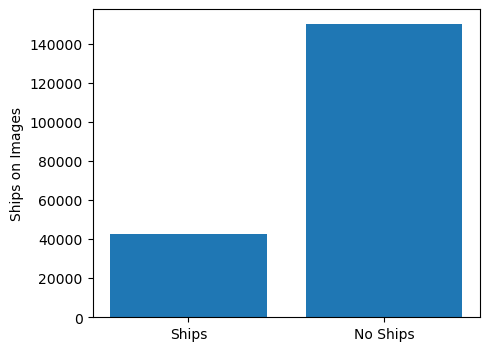

In [9]:
ships = train_mask[~train_mask.EncodedPixels.isna()].ImageId.unique()
noships = train_mask[train_mask.EncodedPixels.isna()].ImageId.unique()

plt.figure(figsize=(5,4))
plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Ships on Images');

As we can see, there are more than three times more pictures without ships than there are pictures with ships. The data is unbalanced, so we will need to balanced it somehow.

#### Decoding RLE masks

The train_ship_segmentations.csv file is in run-length encoding format. For training mode we need to decode mask. 

[RLE](url_here) is run-length encoding. It is used to encode the location of foreground objects in segmentation. Instead of outputting a mask image, you give a list of start pixels and how many pixels after each of those starts is included in the mask. 
Here is the [example](https://www.kaggle.com/code/pestipeti/decoding-rle-masks).

In [10]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

Next functions "multi_rle_encode", "rle_encode" and "masks_as_image" were taken from [this](https://www.kaggle.com/code/hmendonca/u-net-model-with-submission) Kaggle notebook. 

In [11]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

Text(0.5, 1.0, 'Re-encoded')

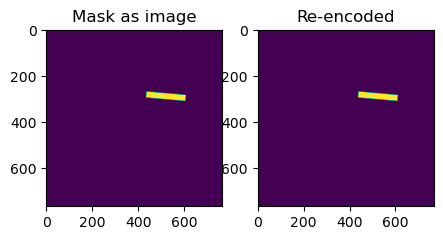

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 5))
rle_0 = train_mask.query('ImageId=="fffdd2377.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')

And this is the same image without mask:


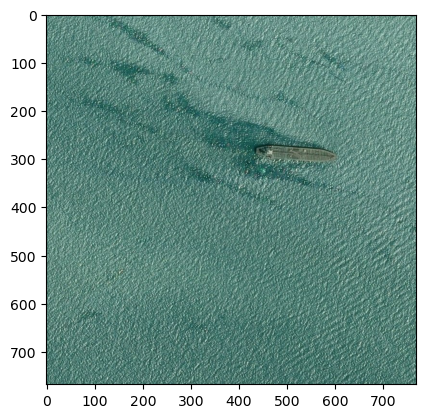

In [13]:
img = plt.imread(r'train_v2\fffdd2377.jpg')
plt.imshow(img)
plt.show()

### Create train/validation split

(from https://www.kaggle.com/code/uysimty/ship-detection-using-keras-u-net)

In [14]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(train_mask)

In [15]:
def get_image(image_name):
    img = imread('train_v2'+image_name)[:,:,:IMG_CHANNELS]
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT), mode='constant', preserve_range=True)
    return img
    
def get_mask(code):
    img = rle_decode(code)
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT, 1), mode='constant', preserve_range=True)
    return img

In [16]:
def create_image_generator(precess_batch_size, data_df):
    while True:
        for k, group_df in data_df.groupby(np.arange(data_df.shape[0])//precess_batch_size):
            imgs = []
            labels = []
            for index, row in group_df.iterrows():
                # images
                original_img = get_image(row.ImageId) / 255.0
                # masks
                mask = get_mask(row.EncodedPixels) / 255.0
                
                imgs.append(original_img)
                labels.append(mask)
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [17]:
train_generator = create_image_generator(batch_size, train_df)
validate_generator = create_image_generator(batch_size, validate_df)

## 2-Model

The goal of the this project is to build a semantic segmentation model. 

[Image segmentation](https://www.superannotate.com/blog/guide-to-semantic-segmentation) is the process of partitioning an image into several regions. The pixels of these regions generally should share certain characteristics.

However, in general, there are three groups of image segmentation tasks:
- Semantic segmentation
- Instance segmentation
- Panoptic segmentation

Semantic segmentation is simply the task of assigning a class label to every single pixel of an input image. The following image presents differences between various computer vision tasks.
![convert notebook to web app](https://uploads-ssl.webflow.com/614c82ed388d53640613982e/63f4963f918240ce0aa5c631_what%20is%20semantic%20segmentation.jpg)

The defining feature of semantic segmentation that differentiates it from instance segmentation is that it does not distinguish between different objects that belong to the same class.


### U-Net architecture


U-Net is a semantic segmentation technique originally proposed for medical imaging segmentation. 


![image.png](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2022/02/1_unet_architecture_paper-768x427.png?lossy=1&strip=1&webp=1)

U-Net architecture (image source: [U-Net paper](https://arxiv.org/abs/1505.04597)).

First sight, it has a “U” shape. The architecture is symmetric and consists of two major parts — the left part is called contracting path, which is constituted by the general convolutional process; the right part is expansive path, which is constituted by transposed 2d convolutional layers(you can think it as an upsampling technic for now).


More about the architecture [here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/).

### Loss-function

We will use Dice coeficient as a loss function for the model.

(from [Understanding DICE COEFFICIENT](https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient))

The Dice Coefficient Loss is a loss function used in machine learning for tasks such as image segmentation. 

- The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth.
- Dice coefficient is 2 times The area of Overlap divided by the total number of pixels in both the images

- Dice coefficient is 2 times The area of Overlap divided by the total number of pixels in both the images
![img2](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png)

The formula is given by:

$$\huge \frac{2*|X∩Y|}{|X|+|Y|}$$

where X is the predicted set of pixels and Y is the ground truth

- The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each image in the test set.

In [18]:
def dice_coef(y_true, y_pred):
    intersect = np.sum(y_true*y_pred)
    fsum = np.sum(y_true)
    ssum = np.sum(y_pred)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

### U-Net building

In [19]:
def build_model(input_layer, start_neurons):
    # Contracting Path
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # Expansive Path
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [20]:
input_layer = Input((768,768,3))
output_layer = build_model(input_layer, 16)

In [21]:
unet_model = keras.Model(input_layer, output_layer)

In [22]:
unet_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[dice_coef])

In [23]:
# use for development to run it faster
if FAST_RUN:
    train_mask = train_mask.sample(n=10000).reset_index().drop(columns=["index"]) # after reset index dataframe will have one more column call index
    

In [24]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 768, 768, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

### Fit Model

In [27]:
train_steps=np.ceil(float(train_df.shape[0]) / float(batch_size)).astype(int)
validate_steps=np.ceil(float(validate_df.shape[0]) / float(batch_size)).astype(int)

In [28]:
history = unet_model.fit_generator(
    train_generator, 
    steps_per_epoch=train_steps,
    validation_data=validate_generator,
    validation_steps=validate_steps,
    epochs=epochs
)

C:\Users\Owner\AppData\Local\Temp\ipykernel_17920\1045712109.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = unet_model.fit_generator(


StopIteration: 

In [ ]:
def get_test_image(image_name):
    img = imread('test_v2'+image_name)[:,:,:IMG_CHANNELS]
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT), mode='constant', preserve_range=True)
    return img
    
def create_test_generator(precess_batch_size):
    while True:
        for k, ix in sub_df.groupby(np.arange(sub_df.shape[0])//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                original_img = get_test_image(row.ImageId) / 255.0
                imgs.append(original_img)
                
            imgs = np.array(imgs)
            yield imgs

In [ ]:
test_generator = create_test_generator(batch_size)

### Training

In [ ]:
# function from https://www.kaggle.com/code/krishanudb/keras-based-unet-model-construction-tutorial

def model_train(model, x, y, epochs, num_test, early_stopper, patience_lr, model_name):
    num_data = x.shape[0]
    num_train = num_data - num_test
    early_stopper = EarlyStopping(patience=early_stopper, verbose=1)
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor = 0.75, patience = patience_lr, verbose=1)
    checkpointer = ModelCheckpoint(model_name + '.h5', verbose=1, save_best_only=True)
    checkpointer_train = ModelCheckpoint(model_name + 'best_train.h5', monitor='loss', verbose=1, save_best_only=True)
    results = model.fit(x[0:num_train], y[0:num_train], validation_data=(x[num_train:], y[num_train:]), batch_size=5, epochs=epochs, callbacks=[early_stopper, checkpointer, checkpointer_train, reduce_learning_rate])
    return model, results

In [ ]:
unet_model, results = model_train(unet_model, train_temp_img, train_temp_mask, 30, 50, 8, 6, 'unet_model')